# Probability Estimation via Scoring

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Vector Graphics
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss, mean_squared_error, brier_score_loss, roc_auc_score, accuracy_score, r2_score
from sklearn.utils import check_random_state

<div align="justify">

There are various methods in machine learning for inducing probabilistic predictors.
These are hypotheses $h$ that do not merely output point predictions $h(\vec{x}) \in \mathcal{Y}$, 
i.e., elements of the output space $\mathcal{Y}$, 
but probability estimates $p_h(\cdot \vert \vec{x}) =  p(\cdot \vert \vec{x}, h)$, 
i.e., complete probability distributions on $\mathcal{Y}$. 
In the case of classification, 
this means predicting a single (conditional) probability $p_h(y \vert \vec{x}) = p(y \vert \vec{x} , h)$ for each class $y \in \mathcal{Y}$, 
whereas in regression, $p( \cdot \vert \vec{x}, h)$ is a density function on $\mathbb{R}$. 
Such predictors can be learned in a discriminative way, 
i.e., in the form of a mapping $\vec{x} \mapsto p( \cdot \vert \vec{x})$, 
or in a generative way, which essentially means learning a joint distribution on $\mathcal{X} \times \mathcal{Y}$. 
Moreover, the approaches can be parametric (assuming specific parametric families of probability distributions) or non-parametric. 
Well-known examples include classical statistical methods such as [logistic regression](logistic) 
and [linear regression](linear). 
Bayesian approaches such as [Bayesian neural networks](../chapter-bayesian_neuralnetwork/bayesian) and [Gaussian processes](../chapter-gaussianprocess/intro), 
as well as various techniques in the realm of [(deep) neural networks](../chapter-deep_neuralnetwork/dnn).  

</div>

(logistic)=
## Probabilistic Predictor with Logistic Regression

<div align="justify">

Since there is no standard metric for comparing the accuracy of probability estimates, 
we use three different metrics to compare the probability estimates given by each example. \
Let us first take a look at an example in the classification task. 
Logistic regression is a widely used supervised machine learning method for binary classification that provides probabilistic outputs. 
Below is an example using `scikit-learn`. 
We make a synthetic binary classification dataset. 
Since the dataset has 20 features, 
it can be challenging to visualize all features at once. Instead, we use the first two features for a simple scatter plot.

</div>

In [2]:
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

X_2d = X[:, :2] 
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, test_size=0.2, random_state=42)

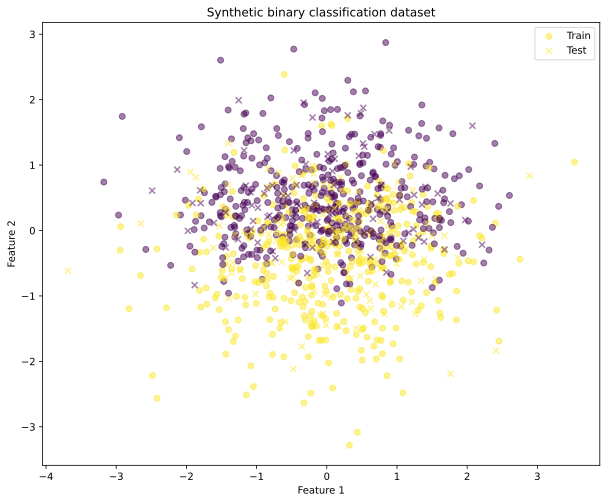

In [3]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', marker='o', alpha=0.5, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='x', alpha=0.5, label='Test')
plt.title('Synthetic binary classification dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

<div align="justify">

Below we plot the decision boundary for a logistic regression model using the first two features as well.

</div>

In [4]:
model = LogisticRegression()
model.fit(X_train, y_train)

h = .02
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

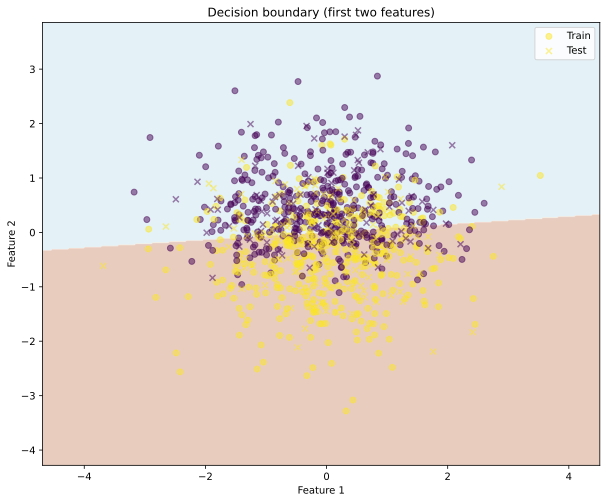

In [5]:
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', alpha=0.5, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', alpha=0.5, label='Test')
plt.title('Decision boundary (first two features)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

<div align="justify">

Training probabilistic predictors is typically accomplished by minimizing suitable loss functions, 
i.e., loss functions that enforce "correct" (conditional) probabilities as predictions. 
In this regard, `proper scoring rules` ({cite:t}`gnei_sp05`) 
play an important role, 
including the `log-loss` as a well-known special case. 
Sometimes, however, estimates are also obtained in a very simple way, 
following basic frequentist techniques for probability estimation, 
like in Naïve Bayes or nearest neighbor classification. 

</div>

<div align="justify">

Scoring rules assess the quality of probabilistic forecasts, by assigning a numerical score based on the predictive distribution and on the event or value that materializes. A scoring rule is proper if the forecaster maximizes the expected score for an observation drawn from the distribution $F$ if he or she issues the probabilistic forecast $F$, rather than $G \neq F$. It is strictly proper if the maximum is unique. In prediction problems, proper scoring rules encourage the forecaster to make careful assessments and to be honest. In estimation problems, strictly proper scoring rules provide attractive loss and utility functions that can be tailored to the problem at hand ({cite:t}`gnei_sp05`).

</div>

<div align="justify">

```{attention}
In the following, we introduce some of scoring methods that can be applied to classification tasks. 
In these mathematical formulas, 
$N$ denotes the number of observations or data points in the dataset.
```

</div>

(bs)=
### Brier Score

<div align="justify">

The Brier Score ({cite:t}`brier_verification_1950`) 
(Quadratic Score) is a strictly proper scoring rule which measures the accuracy of probabilistic predictions, 

$$
S_{\text{Brier}}= \frac{1}{N} \sum_{i=1}^N (p_i-y_i)^2.
$$

</div>

In [6]:
def calculate_bs(y_true, p_pred):
    return np.mean((np.array(p_pred) - np.array(y_true)) ** 2)

<div align="justify">

```{note}
The Brier score can be thought of as a cost function. Thus lower values indicate better performance. 
In its most common formulation, it takes on a value between 0 and 1, 
since this is the square of the largest possible difference between a predicted probability and the actual outcome. 
The Brier score is appropriate for binary and categorical outcomes that can be structured as true or false, 
but it is inappropriate for ordinal variables which can take on three or more values.
```

</div>

### Logarithmic Score

<div align="justify">

The Logarithmic (Log) Score is also often used in the context of probability forecasting, 

$$
S_{\text{Log}} = -\sum_{i=1}^N y_i \log(p_i).
$$

</div>

In [7]:
def calculate_ls(y_true, p_pred):
    y_true = np.array(y_true)
    p_pred = np.array(p_pred)
    epsilon = 1e-15
    p_pred = np.clip(p_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(p_pred))

<div align="justify">

```{note}
The epsilon $\epsilon$ is a very small number to prevent taking the log of zero. 
```

</div>

(ll)=
### Log Loss

<div align="justify">

It measures the performance of a classification model where the prediction is a probability value between 0 and 1, 

$$
L = -\frac{1}{N} \sum_{i=1}^N \left(y_i \log(p_i) + (1-y_i) \log(1-p_i) \right).
$$

</div>

In [8]:
def calculate_ll(y_true, p_pred):
    y_true = np.array(y_true)
    p_pred = np.array(p_pred)
    epsilon = 1e-15
    p_pred = np.clip(p_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(p_pred) + (1 - y_true) * np.log(1 - p_pred))

<div align="justify">

```{hint}
The Log Loss, Logarithmic Loss, Logistic Loss, and Cross-entropy Loss are used interchangeably. 
```

</div>

### Area Under the Receiver Operating Characteristic Curve

<div align="justify">

The area under the curve (AUC) is widely used to measure the accuracy of diagnostic tests. 
The receiver operating characteristic (ROC) curve aims to classify the state as either positive or negative based on test results and to find the optimal cut-off value with the best diagnostic performance. 
The ROC curve is also used to evaluate the overall diagnostic performance of a test and to compare the performance of two or more tests.
The closer the ROC curve is to the upper left corner of the graph, the higher the accuracy of the test because in the upper left corner, 
and vice versa ({cite:t}`nahm_receiver_2022`) . 

</div>

<div align="justify">

Now we leverage these score (loss) function to see the performance of the logistic regression. 
For simplicity, we directly show the performance using metric functions imported from the `scikit-learn` if there already exists the implementation.

</div>

In [9]:
y_pred = model.predict(X_test)
p_pred = model.predict_proba(X_test)[:, 1]

loss = log_loss(y_test, p_pred)
accuracy = accuracy_score(y_test, y_pred)
brier_score = brier_score_loss(y_test, p_pred)
log_score = -np.mean(np.log(p_pred[y_test == 1]))
aucroc_score = roc_auc_score(y_test, p_pred)

print(f"Log Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Brier Score: {brier_score:.4f}")
print(f"Logarithmic Score: {log_score:.4f}")
print(f"AUCROC Score: {aucroc_score:.4f}")

Log Loss: 0.5899
Accuracy: 0.6850
Brier Score: 0.2039
Logarithmic Score: 0.6852
AUCROC Score: 0.7533


(linear)=
## Linear Regression

<div align="justify">

Now we show another example for the regression task. 
In statistics, linear regression is a statistical model used for predicting a continuous target variable. Let us also plot a synthetic regression dataset first.

</div>

In [10]:
n = 200
X = np.arange(n)
rs = check_random_state(0)
y = rs.randint(-50, 50, size=(n,)) + 50.0 * np.log1p(np.arange(n))

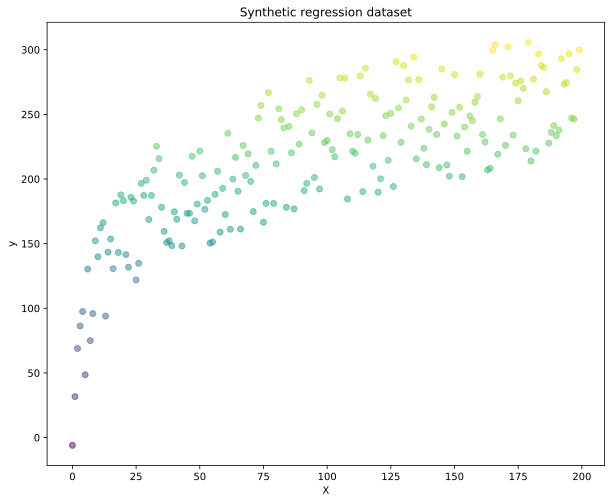

In [11]:
plt.figure(figsize=(10, 8))
plt.scatter(X, y, c=y, cmap='viridis', marker='o', alpha=0.5)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Synthetic regression dataset")
plt.show()

<div align="justify">

Then we train a linear regressor on this dataset and plot them.

</div>

In [12]:
model = LinearRegression()
model.fit(X[:, np.newaxis], y)

y_pred = model.predict(X[:, np.newaxis])

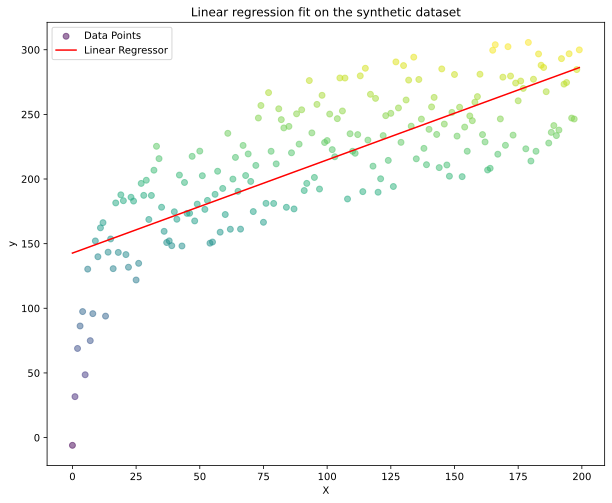

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(X, y, c=y, cmap='viridis', marker='o', alpha=0.5, label='Data Points')
plt.plot(X, y_pred, c='red', label='Linear Regressor')
plt.xlabel("X")
plt.ylabel("y")
plt.title("Linear regression fit on the synthetic dataset")
plt.legend()
plt.show()

### Continuous Ranked Probability Score

<div align="justify">

The Continuous Ranked Probability Score (CRPS) applies to probabilistic forecasts that take the form of predictive cumulative distribution functions. It generalizes the absolute error and forms a special case of a new and very general type of score, the energy score. Like many other scoring rules, the energy score admits a kernel representation in terms of negative definite functions, with links to inequalities of Hoeffding type, in both univariate and multivariate settings ({cite:t}`gnei_sp05`). 

The CRPS is defined as follows:

$$
\text{CRPS}(F, y) = \int_{-\infty}^{\infty} \left( F(x) - \mathbf{1}\{x \geq y\} \right)^2 \, dx,
$$

where $F$ is the cumulative distribution function (CDF) of the forecast, $y$ is the observed value, and $\mathbf{1}\{x \geq y\}$ is the indicator function, which is 1 if $x \geq y$ and 0 otherwise. 

For a Gaussian (normal) predictive distribution with mean $\mu$ and standard deviation $\sigma$, 
the CRPS can be computed using a closed-form solution:

$$
\text{CRPS}(F, y) = \sigma \left[ \frac{y - \mu}{\sigma} \left( 2\Phi\left( \frac{y - \mu}{\sigma} \right) - 1 \right) + 2\phi\left( \frac{y - \mu}{\sigma} \right) - \frac{1}{\sqrt{\pi}} \right], 
$$

where $\Phi$ is the CDF of the standard normal distribution and $\phi$ is the probability density function (PDF) of the standard normal distribution.

</div>

In [14]:
def calculate_crps(y_true, y_pred):
    residuals = y_true - y_pred
    y_std = np.std(residuals)
    if y_std == 0:
        return 0
    crps_values = []
    
    for i in range(len(y_true)):
        mu = y_pred[i]
        sigma = np.std(residuals)
        obs = y_true[i]
        term1 = np.abs(obs - mu)
        term2 = sigma * (1 / np.sqrt(np.pi))
        term3 = 2 * sigma * norm.pdf((obs - mu) / sigma)
        crps_value = term1 + term2 - term3
        crps_values.append(crps_value)
    
    crps = np.mean(crps_values)
    
    return crps / y_std

(mse)=
### Mean Square Error

<div align="justify">

In statistics, the mean squared error (MSE) or mean squared deviation (MSD) of an estimator (of a procedure for estimating an unobserved quantity) measures the average of the squares of the errors,

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^N (\hat{y_i}-y_i)^2.
$$

</div>

In [15]:
def calculate_mse(y_true, y_pred):
    mse = np.mean((np.array(y_pred) - np.array(y_true)) ** 2)
    variance = np.var(y_true)
    return mse / variance

<div align="justify">

```{note}
The Mean Squared Error is a more general measure of accuracy, used primarily in regression tasks. 
It measures the average of the squares of the differences between predicted values and actual values. 
While the Brier Score is used specifically for probabilistic predictions in binary classification tasks. 
It measures the mean squared difference between predicted probabilities and the actual binary outcomes.
```

</div>

### $R^2$

<div align="justify">

R-squared (coefficient of determination) measures the proportion of the variance in the dependent variable that is predictable from the independent variables, normally ranging from 0 to 1. 
Mathematically, it is defined as follows:

$$
R^2 = 1 - \frac{\sum_{i=1}^N (y_i-\hat{y_i})^2}{\sum_{i=1}^N (y_i-\bar{y_i})^2}.
$$

</div>

In [16]:
def calculate_r_squared(y_true, y_pred):
    error = y_pred - y_true
    sse = (error ** 2).sum()
    tss = ((y_true - y_true.mean()) ** 2).sum()    
    return 1 - sse / tss

<div align="justify">

Similarly, 
we here leverage these score (loss) function to see the performance of the linear regression. 
For simplicity, we directly show the performance using metric functions imported from the `scikit-learn` if there already exists the implementation.

</div>

In [17]:
crps_score = calculate_crps(y, y_pred)
mse = calculate_mse(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Continuous Ranked Probability Score: {crps_score:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Continuous Ranked Probability Score: 0.7873
Mean Squared Error: 0.4079
R^2 Score: 0.5921


<div align="justify">

```{note}
We here calculate the Mean Squared Error (MSE), $R^2$, and Continuous Ranked Probability Score (CRPS) for this regression problem because Brier Score and Logarithmic Score are typically used for probabilistic classification models. 
Thus, forecast evaluators should routinely consider choosing scoring rules from these families that are tailored to the domain, as opposed to relying on popular, default scoring rules ({cite:t}`merkle_choosing_2013`).
```

</div>